# Tutorial 2: Melt

# A quick Lithospheric Model with visco-plastic non-linear rheologies and Melt

**Romain Beucher** romain.beucher (at) anu.edu.au

The following notebook reproduce the numerical model presented in Rey et al, 2009

Rey, P. F., Teyssier, C., & Whitney, D. L. (2009). The role of partial melting and extensional strain rates in the development of metamorphic core complexes. Tectonophysics, 477(3–4), 135–144. https://doi.org/10.1016/j.tecto.2009.03.010


![Rey_et_al_2009_Figure_1](images/Rey_et_al2009.png)



In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis
import numpy as np

loaded rc file /home/julian/codes/uw_soft/UWGeo_worktree/development/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


# Working with units

Note that this is not an obligation and you can use values without units 


The geodynamics module enables usage of a broad range of units using a *UnitRegistry*. You can attach a unit to any value that you need to define. A value with a units attached becomes a *Quantity* python object. The geodynamics module take care of the conversion internally so you may use any units that you think are appropriate. You can also mix them.

The module will also try to work out a scaling of the values to help the computation process. The user can chose to alter the way his or her values are scaled or can rely on the default options.

To use the units system, you can link the unit registry as follow:

In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 25.5 * u.millimeter / u.year
model_length = 270e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3370 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# Model setup

The starting model is 270 km long and 90 km thick, and includes 15 km of air-like material (low density, low viscosity) and a 60 km thick crust above 15 km of upper mantle. A weak prismatic region dipping 45° simulates a detachment fault in the upper crust.

In [4]:
Model = GEO.Model(elementRes=(180, 60), 
                  minCoord=(0. * u.kilometer, -75. * u.kilometer), 
                  maxCoord=(270. * u.kilometer, 15. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

	Global element size: 180x60
	Local offset of rank 0: 0x0
	Local range of rank 0: 180x60
In func WeightsCalculator_CalculateAll(): for swarm "4KOU1MXX__swarm"
	done 33% (3600 cells)...
	done 67% (7200 cells)...
	done 100% (10800 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "4KOU1MXX__swarm"


In [5]:
Model.outputDir="outputs_tutorial2"

For all rocks, we assume a heat capacity of 1000 J kg−1 K−1 and thermal diffusivity of 9·10−7 m2 s−1. The crustal thermal conductivity is therefore 2.45 W m−1 K−1.

In [6]:
Model.diffusivity = 9e-7 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

### Air Layer

In [7]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0 * u.kilometer))
air.density = 1. * u.kilogram / u.metre**3
air.diffusivity = 1e-6 * u.metre**2 / u.second
air.capacity = 1000. * u.joule / (u.kelvin * u.kilogram)

### Continental Crust

Because the composition of the continental crust changes with depth,
an increase in density is expected toward the Moho. However,we assume that this density increase is balanced by the density decrease related to thermal expansion, and therefore we choose a depth and temperature independent density for the continental crust of 2720 kgm−3.

In [8]:
continentalcrust = Model.add_material(name="Continental Crust", shape=GEO.shapes.Layer(top=0. * u.kilometer, bottom=-60. * u.kilometer))
continentalcrust.radiogenicHeatProd = 7.67e-7 * u.watt / u.meter**3
continentalcrust.density  = 2720. * u.kilogram / u.metre**3

### Upper-Mantle

At room conditions, the density of the mantle is 3370kgm−3 and has a coefficient of thermal expansion of 2.8·10−5 K−1

In [9]:
uppermantle = Model.add_material(name="Upper Mantle", shape=GEO.shapes.Layer(top=-60. * u.kilometer, bottom=Model.bottom))
uppermantle.density = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3,
                                        thermalExpansivity= 2.8e-5 * u.kelvin**-1)

### Fault

In [10]:
vertices = [(124.  * u.kilometer,  0. * u.kilometer),
            (127. * u.kilometer,   0. * u.kilometer),
            (146. * u.kilometer, -20. * u.kilometer),
            (143. * u.kilometer, -20. * u.kilometer)]

fault = Model.add_material(name="Fault", shape=GEO.shapes.Polygon(vertices))
fault.density = 2720. * u.kilogram / u.metre**3
fault.radiogenicHeatProd = 7.67e-7 * u.watt / u.meter**3


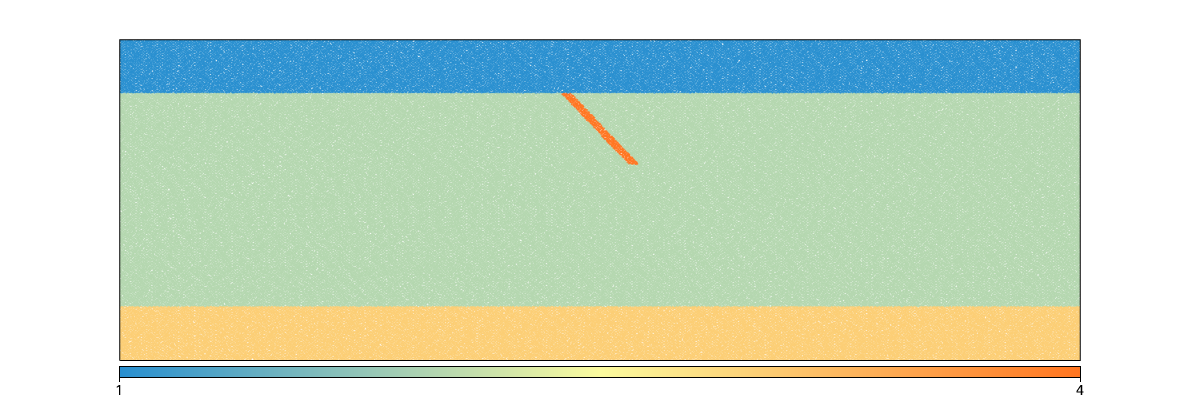

In [11]:
FigMat = vis.Figure(figsize=(1200,400))
FigMat.Points(Model.swarm, Model.materialField, fn_size=2.0)
FigMat.show()

# Define Viscosities

The crust and the mantle have a visco-plastic rheology with a
temperature and stress dependent viscosity for stresses below the yield stress,
and a depth dependent plastic branch above it.
We use power law relationships between strain rate and stress
to describe dislocation creep. 

The viscosity varies with the temperature and stress according to:

crust, A, n and Q are those of quartz-rich rock (pre-exponent Ac=5·10−6 MPa−nc
s−1, nc=3, Qc=1.9·105 Jmol−1, Goetze,
1978). The pre-exponent factor for the fault is 10 · Ac which makes the fault ten times less viscous than the crust in which it is embedded. The rheology of the mantle is that of dry olivine (pre-exponent Am= 7·104 MPa−nc
s−1, nm=3, Qm=5.2·105 J mol−1, Brace and Kohlstedt,
1980). In

In [12]:
rh = GEO.ViscousCreepRegistry()

In [13]:
Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second

air.viscosity = 5e18 * u.pascal * u.second
continentalcrust.viscosity = rh.Wet_Olivine_Dislocation_Goetze_et_al_1978
uppermantle.viscosity = rh.Wet_Dunite_Dislocation_Brace_and_Kohlstedt_1980
fault.viscosity = 0.1 * rh.Wet_Olivine_Dislocation_Goetze_et_al_1978

In [14]:
continentalcrust

In [15]:
uppermantle

In [16]:
fault

In the crust and the mantle, frictional sliding is modeled via a Mohr
Coulomb criterion with a cohesion (C0) of 15 MPa and a coefficient of friction (µ) of 0.44. 
The cohesion and coefficient of internal friction in the detachment fault are C0/10 and µ/10, respectively.
In all material, the yield stress linearly drops to a maximum of 20% of its initial value when the accumulated strain reaches 0.5 (cf.Wijns et al., 2005 for details). For differential stresses reaching the yield stress, the material fails and deformation is modeled by an effective viscosity: ηyield=τyield/(2 · E) in which E is the second invariant of the strain rate tensor. For semi-brittle effects, we impose a maximum yield stress of 250 MPa for the crust, 400MPa for the mantle and 10 MPa for the fault.

In [17]:
continentalcrust.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)

uppermantle.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                           cohesion=15. * u.megapascal,
                                           cohesionAfterSoftening=3. * u.megapascal,
                                           frictionCoefficient=0.44,
                                           frictionAfterSoftening=0.088,
                                           epsilon1=0.0, epsilon2=0.5)

fault.plasticity = GEO.DruckerPrager(name="Fault", 
                                     cohesion=1.5 * u.megapascal,
                                     cohesionAfterSoftening=0.3 * u.megapascal,
                                     frictionCoefficient=0.44,
                                     frictionAfterSoftening=0.088,
                                     epsilon1=0.0, epsilon2=0.5)

## Melt

In [18]:
solidii = GEO.SolidusRegistry()
crust_solidus = solidii.Crustal_Solidus

liquidii = GEO.LiquidusRegistry()
crust_liquidus = liquidii.Crustal_Liquidus

In our experiments, the viscosity decreases linearly by 3 orders of magnitude when the melt fraction increases from 15 to 30%. When the melt fraction is 15%, the viscosity of the melted crust is that of the non-melted surrounding; when the melt fraction is 30%, its viscosity is a thousand times lower than in surrounding material. Rosenberg and Handy (2005) showed that significant weakening occurs at 7% melt fraction.

In [19]:
continentalcrust.add_melt_modifier(crust_solidus, crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )  

fault.add_melt_modifier(crust_solidus, crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )

## Temperature Boundary Condition
The geotherm is based on a constant heat flow imposed at the base of the model (0.022 W m−2), a constant temperature imposed at the top (20 °C).

In [20]:
Model.set_temperatureBCs(top=293.15 * u.degK, materials=[(air, 293.15*u.degK)])

In [21]:
Model.set_heatFlowBCs(bottom=(0.022 * u.watt / u.metre**2, uppermantle))

## Velocity Boundary Conditions

In [22]:
Model.set_velocityBCs(left=[-25.5 * u.millimeter / u.year, None],
                       right=[25.5 * u.millimeter / u.year, None],
                       bottom=[None, 0.])

## Interface Tracers

In [23]:
npoints = 1000 # This is the number of points used to define the surface
coords = np.ndarray((1000, 2))

coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), 1000)
coords[:, 1] = 0.

Model.add_passive_tracers(name="Surface", vertices=coords)

coords[:, 1] -= GEO.nd(60.*u.kilometer)
Model.add_passive_tracers(name="Moho", vertices=coords)

## Grid Tracers

In [24]:
pts = GEO.circles_grid(radius=2.0*u.kilometer, 
                       minCoord=[Model.minCoord[0], continentalcrust.bottom], 
                       maxCoord=[Model.maxCoord[0], 0.*u.kilometer])

Model.add_passive_tracers(name="FSE_Crust", vertices=pts)

## Lagrangian Grid

In [25]:
cxpos = np.linspace(GEO.nd(115*u.kilometer), GEO.nd(155*u.kilometer),5)
cypos = np.linspace(GEO.nd(-40*u.kilometer), GEO.nd(-10*u.kilometer),5)

cxpos, cypos = np.meshgrid(cxpos, cypos)
centroid_coords = np.ndarray((len(cxpos.ravel()), 2))
centroid_coords[:, 0] = cxpos.ravel()
centroid_coords[:, 1] = cypos.ravel()

point = np.zeros((1, 2))

Model.add_passive_tracers(name="Lag_grid", vertices=point, centroids=centroid_coords)


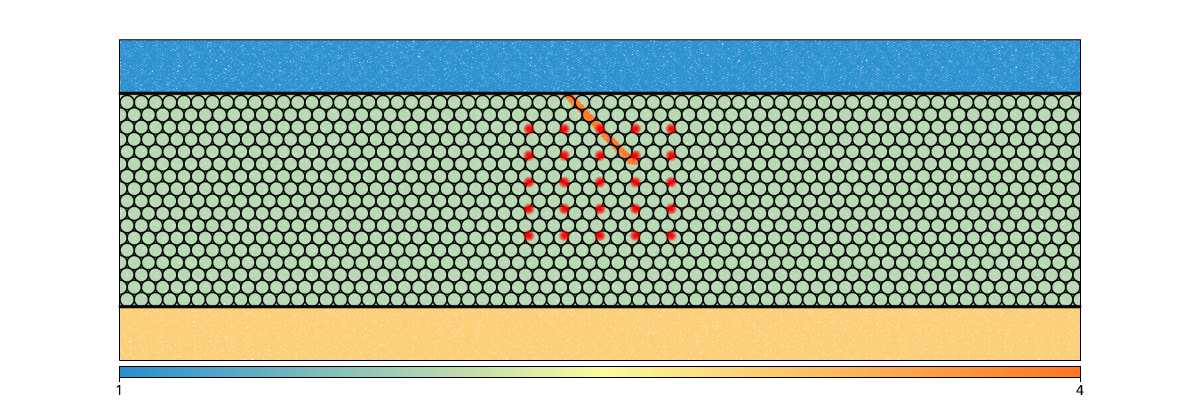

In [26]:
FigMat = vis.Figure(figsize=(1200,400))
FigMat.Points(Model.Lag_grid_tracers, pointSize=12.0, colour="red")
FigMat.Points(Model.Surface_tracers, pointSize=4.0)
FigMat.Points(Model.Moho_tracers, pointSize=4.0)
FigMat.Points(Model.FSE_Crust_tracers, pointSize=2.0)
FigMat.Points(Model.swarm, Model.materialField, fn_size=2.0)
FigMat.show()

In [27]:
Model.Lag_grid_tracers.add_tracked_field(Model.temperature, name="LagGridTemp", units=u.degC, dataType="float")
Model.Lag_grid_tracers.add_tracked_field(Model.pressureField, name="LagGridPress", units=u.megapascal, dataType="float")

## Run Model

In [28]:
Model.init_model(temperature="steady-state", pressure="lithostatic")

In SystemLinearEquations_NonLinearExecute

Non linear solver - iteration 0
Linear solver (X3N35EG7__system-execute) 
Linear solver (X3N35EG7__system-execute), solution time 3.858862e-02 (secs)
Non linear solver - iteration 1
Linear solver (X3N35EG7__system-execute) 
Linear solver (X3N35EG7__system-execute), solution time 3.671984e-02 (secs)
In func SystemLinearEquations_NonLinearExecute: Iteration 1 of 500 - Residual 0 - Tolerance = 0.01
Non linear solver - Residual 0.00000000e+00; Tolerance 1.0000e-02 - Converged - 1.873410e-01 (secs)

In func SystemLinearEquations_NonLinearExecute: Converged after 1 iterations.



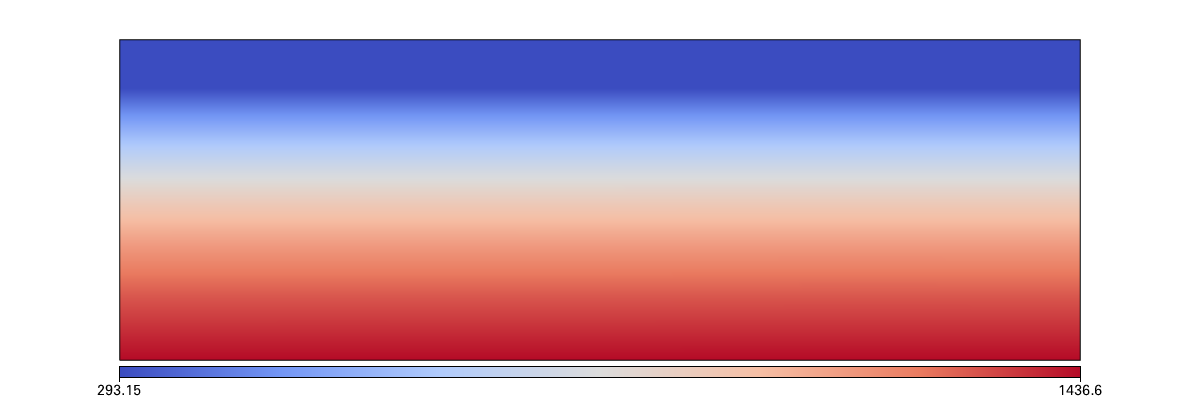

In [29]:
FigTemp = vis.Figure(figsize=(1200,400))
FigTemp.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), colours="coolwarm")
FigTemp.show()


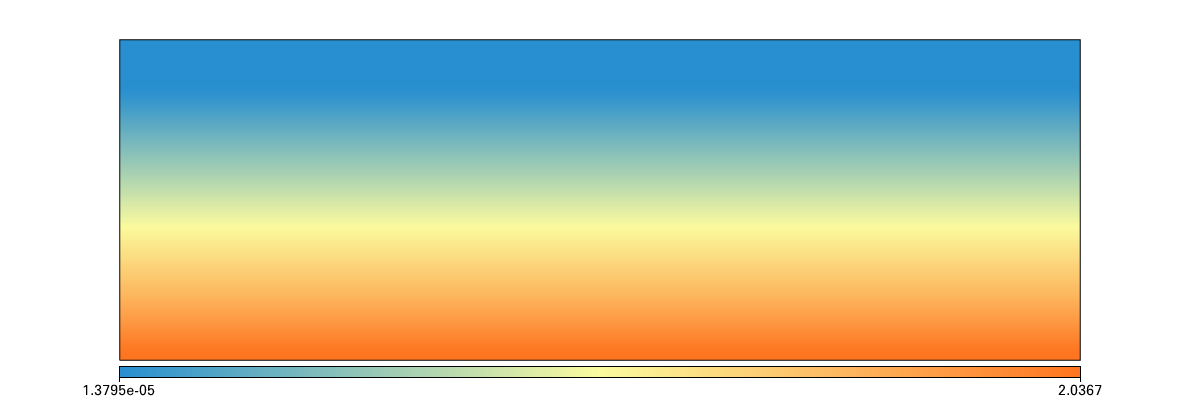

In [30]:
FigPress = vis.Figure(figsize=(1200,400))
FigPress.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.gigapascal))
FigPress.show()

# Extract information

### Temperature at the Moho

<font color='red'>WARNING: The next cell is NOT PARALLEL SAFE and will results in an error if you try to run it on multiple CPUs. You MUST delete it before attempting to run the model in parallel. </font>

In [31]:
if GEO.nProcs == 1:

    moho_average_temperature = Model.temperature.evaluate(Model.Moho_tracers).mean()
    moho_average_temperature = GEO.dimensionalise(moho_average_temperature, u.degC)

    print("Average Temperature at Moho: {0:5.0f}".format(moho_average_temperature))

Average Temperature at Moho: 1054 degC


<font color='red'>WARNING: The next cell is NOT PARALLEL SAFE and will results in an error if you try to run it on multiple CPUs. You MUST delete it before attempting to run the model in parallel. </font>

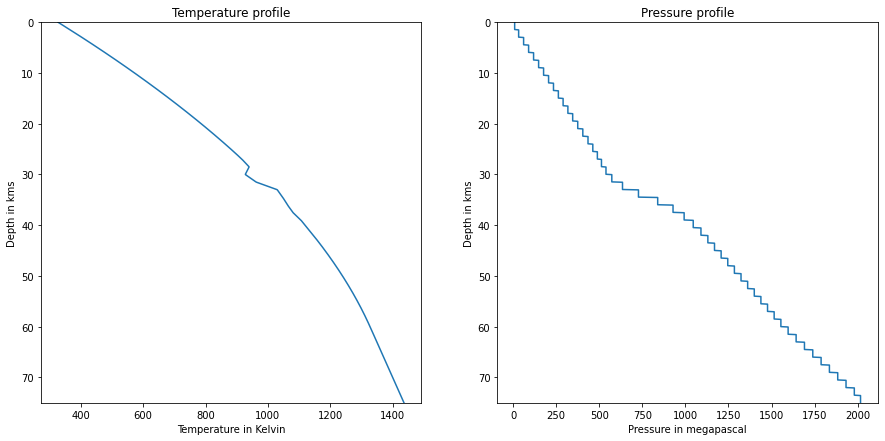

In [41]:
if GEO.nProcs == 1:

    import matplotlib.pyplot as plt

    distances, temperature = GEO.extract_profile(Model.temperature, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])
    distances, pressure = GEO.extract_profile(Model.pressureField, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])

    Fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))
    ax1.plot(GEO.dimensionalise(temperature, u.degK).m, GEO.dimensionalise(distances, u.kilometer).m)
    ax1.set_xlabel("Temperature in Kelvin")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(75, 0)
    ax1.set_title("Temperature profile")

    ax2.plot(GEO.dimensionalise(pressure, u.megapascal).m, GEO.dimensionalise(distances, u.kilometer).m)
    ax2.set_xlabel("Pressure in megapascal")
    ax2.set_ylabel("Depth in kms")
    ax2.set_title("Pressure profile")
    ax2.set_ylim(75, 0)
    plt.show()

## Visualise Solidus and Liquidus

<font color='red'>WARNING: The next cell is NOT PARALLEL SAFE and will results in an error if you try to run it on multiple CPUs. You MUST delete it before attempting to run the model in parallel. </font>

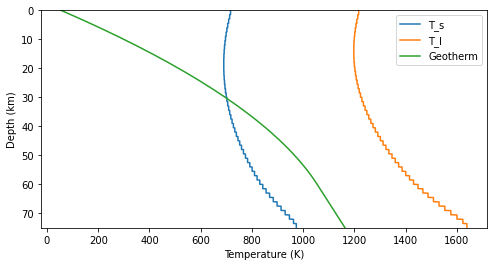

In [40]:
if GEO.nProcs == 1:

    T_s = crust_solidus.temperature(pressure)
    T_l = crust_liquidus.temperature(pressure)
    depths = distances

    import pylab as plt

    fig = plt.figure(figsize=(8,4))
    plt.plot(GEO.dimensionalise(T_s, u.degC).m,GEO.dimensionalise(depths, u.kilometer).m, label="T_s")
    plt.plot(GEO.dimensionalise(T_l, u.degC).m,GEO.dimensionalise(depths, u.kilometer).m, label="T_l")
    plt.plot(GEO.dimensionalise(temperature, u.degC).m,GEO.dimensionalise(depths, u.kilometer).m, label="Geotherm")
    plt.xlabel("Temperature (K)")
    plt.ylabel("Depth (km)")
    plt.legend()
    plt.ylim(75, 0)
    plt.show()


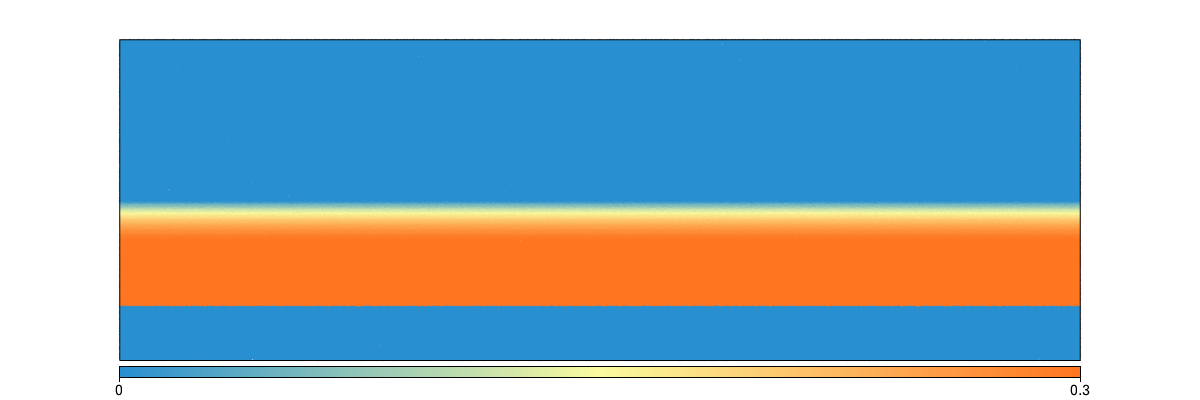

In [34]:
Model.update_melt_fraction()
FigMelt = vis.Figure(figsize=(1200,400))
FigMelt.Points(Model.swarm, Model.meltField, fn_size=3.0)
FigMelt.show()

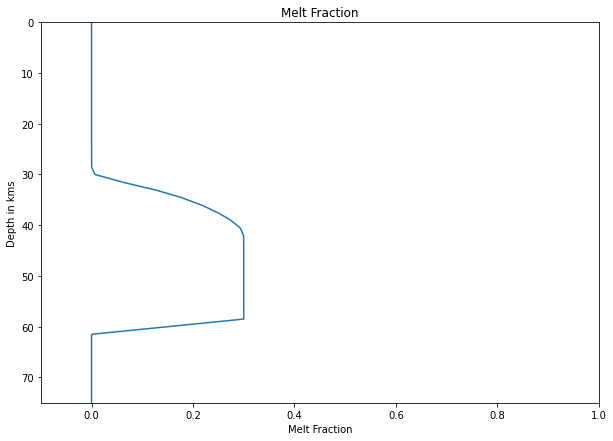

In [35]:
if GEO.nProcs == 1:

    distances, meltFraction = GEO.extract_profile(Model.projMeltField, 
                                                  line = [(180.* u.kilometer, 0.),
                                                          (180.* u.kilometer, Model.bottom)])

    Fig, ax1 = plt.subplots(1,1,figsize=(10,7))
    ax1.plot(meltFraction, GEO.dimensionalise(distances, u.kilometer).m)
    ax1.set_xlabel("Melt Fraction")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(75, 0)
    ax1.set_xlim(-0.1, 1.0)
    ax1.set_title("Melt Fraction")


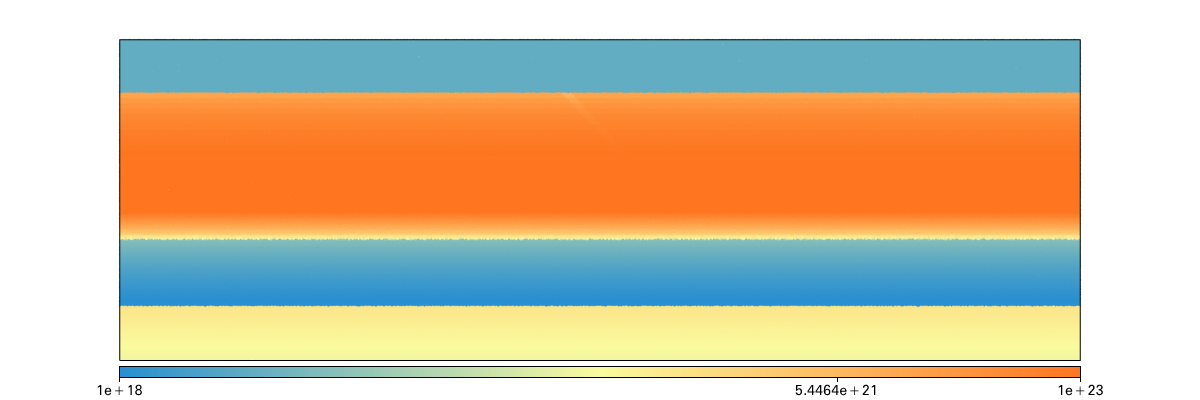

In [36]:
FigVisc = vis.Figure(figsize=(1200,400))
FigVisc.Points(Model.swarm, GEO.dimensionalise(Model.viscosityField, u.pascal*u.second), fn_size=3.0, logScale=True)
FigVisc.show()

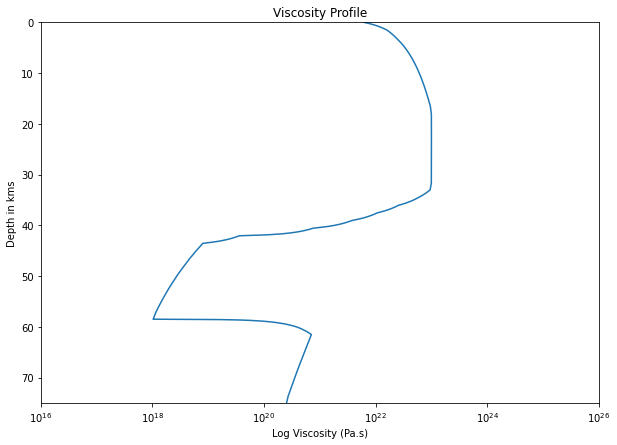

In [37]:
if GEO.nProcs == 1:

    distances, viscosities = GEO.extract_profile(Model.projViscosityField, 
                                                 line = [(180.* u.kilometer, 0.),
                                                         (180.* u.kilometer, Model.bottom)])

    Fig, ax1 = plt.subplots(1,1,figsize=(10,7))
    ax1.plot(GEO.dimensionalise(viscosities, u.pascal*u.second).m, GEO.dimensionalise(distances, u.kilometer).m)
    ax1.set_xscale("log")
    ax1.set_xlabel("Log Viscosity (Pa.s)")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(75, 0)
    ax1.set_xlim(1e16, 1e26)
    ax1.set_title("Viscosity Profile")

In [38]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

In [39]:
Model.run_for(5000.* u.years, checkpoint_interval=1000. * u.year)

Running with UWGeodynamics version 2.13.0-dev-5399900(development)
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
In SystemLinearEquations_NonLinearExecute

Non linear solver - iteration 0
Linear solver (CPG7F1PK__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.039077 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.006811 secs / 1 its
  Pressure Solve:         = 0.01508 secs / 2 its
  Final V Solve:          = 0.006449 secs / 1 its

  Total BSSCR Linear solve time: 0.379856 seconds

Li

1